# Preparation of features and labels

In [2]:
"""pick out features from MineRL data"""
import os 
import json
import numpy as np


def get_npz_json(path):
    #read from npz
    npz_list=[]
    reward=[]
    
    seq_0=[]#0
    seq_1=[]#1
    seq_2=[]#2
    seq_3=[]#3 time_seq for reward
    seq_4=[]#4 order_seq for reward
    acc_reward=[]#3
    reward_mask=[0,16,4,0,32,0,128,64,256,1,2,4,0,0,32,0,0,8]
    
    if_ironaxe=[]#5
    if_stoneaxe=[]#6
    if_woodenaxe=[]#7
    attack_effi=[]#10 Attack efficiency
    attack=[]#11 attack_ratio
    atk_equips=[]#12 Equipped attack ratio
    camera=[]#13 ratio
    moves=[]#14 ratio
    place_torch=[]#15
    place_cobblestone=[]#16
    place_dirt=[]#17
    place_stone=[]#18
    smelt=[]#19
    
    
    #read from json file
    duration_steps=[]
    duration_ms=[]
    true_video_frame_count=[]
    total_reward=[]#8
    stream_name=[]
    #cut_point
    pickaxe_steps=[]
    
    g = os.walk(path)  
    for path,dir_list,file_list in g:
        for dir_name in sorted(dir_list):
#             print(os.path.join(path, dir_name))
            npzPath = os.path.join(path, dir_name)+'/rendered.npz'
            jsonPath = os.path.join(path, dir_name)+'/metadata.json'
            
            with open(jsonPath,'r') as f: 
                jdata=json.load(f)
                steps=0
                steps=jdata["duration_steps"]#used later to calculate ratio
                duration_steps.append(jdata["duration_steps"])
                total_reward.append(jdata["total_reward"])###8
                duration_ms.append(jdata["duration_ms"])
                stream_name.append(jdata["stream_name"])
                true_video_frame_count.append(jdata["true_video_frame_count"])
                
            
            with np.load(npzPath) as f:
                npz_list.append(f)
                
                ###3    
                rwd=f['reward']
                reward.append(f['reward'])
                for step in range(1,len(rwd)):
                    rwd[step]=rwd[step-1]+rwd[step]
                acc_reward.append(rwd)
                
                ###cut_point
                rwd_idx=np.argwhere(rwd==256)
                if rwd_idx.shape==(1,1):
                    pickaxe_step=rwd_idx[0][0]
                else:
                    pickaxe_step=steps
                pickaxe_steps.append(pickaxe_step)
                cut_list=[x for x in range(pickaxe_step+1,steps)]

                
                ###0-2 invs
                invs_array=np.zeros((18,steps+1))
                invs_array[0]=f['observation$inventory$coal']#coal
                invs_array[1]=f['observation$inventory$cobblestone']#cobblestone
                invs_array[2]=f['observation$inventory$crafting_table']#crafting_table
                invs_array[3]=f['observation$inventory$dirt']#dirt
                invs_array[4]=f['observation$inventory$furnace']#furnace
                invs_array[5]=f['observation$inventory$iron_axe']#iaxe
                invs_array[6]=f['observation$inventory$iron_ingot']#iron_ingot
                invs_array[7]=f['observation$inventory$iron_ore']#iron_ore
                invs_array[8]=f['observation$inventory$iron_pickaxe']#iron_pickaxe
                invs_array[9]=f['observation$inventory$log']#log
                invs_array[10]=f['observation$inventory$planks']#planks
                invs_array[11]=f['observation$inventory$stick']#stick
                invs_array[12]=f['observation$inventory$stone']#stone
                invs_array[13]=f['observation$inventory$stone_axe']#stone_axe
                invs_array[14]=f['observation$inventory$stone_pickaxe']#stone_pickaxe
                invs_array[15]=f['observation$inventory$torch']#torch
                invs_array[16]=f['observation$inventory$wooden_axe']#wooden_axe
                invs_array[17]=f['observation$inventory$wooden_pickaxe']#wooden_pickaxe
                
                invs_array=np.delete(invs_array,cut_list,axis=1)
                
                order_seq=np.zeros((1,18))#seq_0
                time_seq=np.zeros((18,1))#seq_1
                inv_counts=np.zeros((18,1))#seq_2
                time_seq_2=np.zeros((18,1))#seq_3 time_seq with reward
                order_seq_2=np.zeros((1,18))#seq_4 order_seq with reward

                for i in range(1,steps+1):
                    increase_array=invs_array[:,i:i+1]-invs_array[:,i-1:i]
                    if np.any(increase_array>0):
                        inv_counts+=np.where(increase_array>0,increase_array,0)
                for i in range(18):
                    inv_counts[i]=inv_counts[i]*reward_mask[i]
                seq_2.append(np.reshape(inv_counts,(18,)))
                
                for ii in range(18):
                    this_inv_seq=invs_array[ii,:]
                    nonz_idx=np.where(this_inv_seq>0)
                    if len(nonz_idx[0])>0:
                        time_seq[ii,0]=nonz_idx[0][0]
                        if reward_mask[ii]!=0:
                            time_seq_2[ii,0]=nonz_idx[0][0]
#                 print("time_seq",time_seq.T)
                seq_1.append(np.reshape(time_seq,(18,)))
                seq_3.append(np.reshape(time_seq_2,(18,)))
                
                order_idx=np.argsort(time_seq.T)
                order_count=1
#                 print("shape",np.shape(order_idx))#(1,18)
                for i in range(18):
                    if time_seq[order_idx[0,i],0]>0:
                        order_seq[0,order_idx[0,i]]=order_count
                        if order_idx[0,i]!=0:
                            order_seq_2[0,order_idx[0,i]]=order_count
                        order_count+=1
                seq_0.append(np.reshape(order_seq,(18,)))
                seq_4.append(np.reshape(order_seq_2,(18,)))
#                 print(order_seq)
                
                
                ###5
                iaxe=invs_array[5]
                ironaxe_count=np.sum(iaxe==1)
                if ironaxe_count>0:
                    if_ironaxe.append(1)
                else:
                    if_ironaxe.append(0)
                ###6    
                saxe=invs_array[13]
                stoneaxe_count=np.sum(saxe==1)
                if stoneaxe_count>0:
                    if_stoneaxe.append(1)
                else:
                    if_stoneaxe.append(0)
                ###7   
                waxe=invs_array[16]
                woodenaxe_count=np.sum(waxe==1)
                if woodenaxe_count>0:
                    if_woodenaxe.append(1)
                else:
                    if_woodenaxe.append(0)
                
                ###11    
                atk_count=0    
                atk=np.delete(f['action$attack'],cut_list)
                atk_count=np.sum(atk==1)
                attack.append(atk_count*1.0/pickaxe_step)#ratio

                
                ###10
                cobblestone=invs_array[1]
                log=invs_array[9]
                iron_ore=invs_array[7]
                total_exinv=0
                for i in range(1,len(log)):
                    if log[i]-log[i-1]>0:
                        total_exinv+=(log[i]-log[i-1])
                    if cobblestone[i]-cobblestone[i-1]>0:
                        total_exinv+=(cobblestone[i]-cobblestone[i-1])
                    if iron_ore[i]-iron_ore[i-1]>0:
                        total_exinv+=(iron_ore[i]-iron_ore[i-1])
                attack_effi.append(total_exinv*1.0/atk_count)
                    
                    
                
                ###14
                move=f['action$forward'] | f['action$left'] | f['action$back'] | f['action$right']\
                        | f['action$jump'] | f['action$sneak'] | f['action$sprint']
                move=np.delete(move,cut_list)
                move_count=np.sum(move==1)
#                 print(move_count)
                moves.append(move_count*1.0/pickaxe_step)
                
                ###19
                smt=np.delete(f['action$nearbySmelt'],cut_list)
                if_smt=0
                for item in smt:
                    if item=='coal':
                        if_smt=1
                        break
                smelt.append(if_smt)
                
                ###15-18
                plc=np.delete(f['action$place'],cut_list)
                plc_count=[0,0,0,0] #[torch, cobblestone, dirt, stone]
                for item in plc:
                    if item=='torch':
                        plc_count[0]+=1
                    if item=='cobblestone':
                        plc_count[1]+=1
                    if item=='dirt':
                        plc_count[2]+=1
                    if item=='stone':
                        plc_count[3]+=1
                place_torch.append(plc_count[0])
                place_cobblestone.append(plc_count[1])
                place_dirt.append(plc_count[2])
                place_stone.append(plc_count[3])
                
                ###13
#                 cmr=np.delete(f['action$camera'],cut_list)
                cmr=f['action$camera']
                cmr_count=0
                for i in range(1,len(cmr)):
                    if cmr[i][0]!=cmr[i-1][0] or cmr[i][1]!=cmr[i-1][1]:
                        cmr_count+=1
                camera.append(cmr_count*1.0/steps)

                ###12
#                 eqp=f['action$equip'] #wrong 
                eqp=np.delete(f['observation$equipped_items.mainhand.type'],cut_list)              
                atk_eqp_count=0
                for ii in range(len(eqp)-1):
                    if eqp[ii]=='stone_pickaxe' or eqp[ii]=='wooden_pickaxe':
                        if atk[ii]==1:
                            atk_eqp_count+=1
#                 eqp_bool=[1 if (x=='stone_pickaxe' or x=='wooden_pickaxe') else 0 for x in eqp]
#                 atk_eqp_count=np.sum((atk & eqp_bool)==1)
                atk_equips.append(atk_eqp_count*1.0/atk_count)#Equipped attack ratio
#                 print(atk_eqp_count)
                    
                
    return seq_0,seq_1,seq_2, seq_3,seq_4, if_ironaxe, if_stoneaxe, if_woodenaxe, attack_effi, reward, acc_reward, npz_list, attack, atk_equips, moves, smelt, place_torch, place_cobblestone, place_dirt, place_stone, camera,\
            duration_steps, total_reward, duration_ms, stream_name, true_video_frame_count


seq_0,seq_1,seq_2, seq_3,seq_4, if_ironaxe, if_stoneaxe, if_woodenaxe, attack_effi, reward, acc_reward, npz_list, attack, atk_equips, moves, smelt, place_torch, place_cobblestone, place_dirt, place_stone, camera,\
duration_steps, total_reward, duration_ms, stream_name, true_video_frame_count=get_npz_json("./data/MineRLObtainDiamond-v0")

ir_seq_0,ir_seq_1,ir_seq_2, ir_seq_3,ir_seq_4, ir_if_ironaxe, ir_if_stoneaxe, ir_if_woodenaxe, ir_attack_effi, ir_reward, ir_acc_reward, ir_npz_list, ir_attack, ir_atk_equips, ir_moves, ir_smelt, ir_place_torch, ir_place_cobblestone, ir_place_dirt, ir_place_stone, ir_camera,\
ir_duration_steps, ir_total_reward, ir_duration_ms, ir_stream_name, ir_true_video_frame_count=get_npz_json("./data/MineRLObtainIronPickaxe-v0")

# attack_effi=total_exinv/attack

In [3]:
np.save("0_seq_0.npy",seq_0, allow_pickle=True, fix_imports=True)
np.save("1_seq_1.npy",seq_1, allow_pickle=True, fix_imports=True)
np.save("2_seq_2.npy",seq_2, allow_pickle=True, fix_imports=True)
np.save("3_seq_3.npy",seq_3, allow_pickle=True, fix_imports=True)
np.save("4_seq_4.npy",seq_4, allow_pickle=True, fix_imports=True)

np.save("5_if_ironaxe.npy",if_ironaxe, allow_pickle=True, fix_imports=True)
np.save("6_if_stoneaxe.npy",if_stoneaxe, allow_pickle=True, fix_imports=True)
np.save("7_if_woodenaxe.npy",if_woodenaxe, allow_pickle=True, fix_imports=True)

np.save("8_total_reward.npy",total_reward, allow_pickle=True, fix_imports=True)
np.save("10_attack_effi.npy",attack_effi, allow_pickle=True, fix_imports=True)
np.save("11_attack.npy",attack, allow_pickle=True, fix_imports=True)
np.save("12_atk_equips.npy",atk_equips, allow_pickle=True, fix_imports=True)
np.save("13_camera.npy",camera, allow_pickle=True, fix_imports=True)
np.save("14_moves.npy",moves, allow_pickle=True, fix_imports=True)

np.save("15_place_torch.npy",place_torch, allow_pickle=True, fix_imports=True)
np.save("16_place_cobblestone.npy",place_cobblestone, allow_pickle=True, fix_imports=True)
np.save("17_place_dirt.npy",place_dirt, allow_pickle=True, fix_imports=True)
np.save("18_place_stone.npy",place_stone, allow_pickle=True, fix_imports=True)
np.save("19_smelt.npy",smelt, allow_pickle=True, fix_imports=True)

np.save("reward.npy",reward, allow_pickle=True, fix_imports=True)
np.save("acc_reward.npy",acc_reward, allow_pickle=True, fix_imports=True)
np.save("npz_list.npy",npz_list, allow_pickle=True, fix_imports=True)
np.save("duration_steps.npy",duration_steps, allow_pickle=True, fix_imports=True)
np.save("duration_ms.npy",duration_ms, allow_pickle=True, fix_imports=True)
np.save("stream_name.npy",stream_name, allow_pickle=True, fix_imports=True)
np.save("true_video_frame_count.npy",true_video_frame_count, allow_pickle=True, fix_imports=True)

In [4]:
np.save("0_ir_seq_0.npy",seq_0, allow_pickle=True, fix_imports=True)
np.save("1_ir_seq_1.npy",seq_1, allow_pickle=True, fix_imports=True)
np.save("2_ir_seq_2.npy",seq_2, allow_pickle=True, fix_imports=True)
np.save("3_ir_seq_3.npy",seq_3, allow_pickle=True, fix_imports=True)
np.save("4_ir_seq_4.npy",seq_4, allow_pickle=True, fix_imports=True)

np.save("5_ir_if_ironaxe.npy",if_ironaxe, allow_pickle=True, fix_imports=True)
np.save("6_ir_if_stoneaxe.npy",if_stoneaxe, allow_pickle=True, fix_imports=True)
np.save("7_ir_if_woodenaxe.npy",if_woodenaxe, allow_pickle=True, fix_imports=True)

np.save("8_ir_total_reward.npy",total_reward, allow_pickle=True, fix_imports=True)
np.save("10_ir_attack_effi.npy",attack_effi, allow_pickle=True, fix_imports=True)
np.save("11_ir_attack.npy",attack, allow_pickle=True, fix_imports=True)
np.save("12_ir_atk_equips.npy",atk_equips, allow_pickle=True, fix_imports=True)
np.save("13_ir_camera.npy",camera, allow_pickle=True, fix_imports=True)
np.save("14_ir_moves.npy",moves, allow_pickle=True, fix_imports=True)

np.save("15_ir_place_torch.npy",place_torch, allow_pickle=True, fix_imports=True)
np.save("16_ir_place_cobblestone.npy",place_cobblestone, allow_pickle=True, fix_imports=True)
np.save("17_ir_place_dirt.npy",place_dirt, allow_pickle=True, fix_imports=True)
np.save("18_ir_place_stone.npy",place_stone, allow_pickle=True, fix_imports=True)
np.save("19_ir_smelt.npy",smelt, allow_pickle=True, fix_imports=True)

np.save("ir_reward.npy",reward, allow_pickle=True, fix_imports=True)
np.save("ir_acc_reward.npy",acc_reward, allow_pickle=True, fix_imports=True)
np.save("ir_npz_list.npy",npz_list, allow_pickle=True, fix_imports=True)
np.save("ir_duration_steps.npy",duration_steps, allow_pickle=True, fix_imports=True)
np.save("ir_duration_ms.npy",duration_ms, allow_pickle=True, fix_imports=True)
np.save("ir_stream_name.npy",stream_name, allow_pickle=True, fix_imports=True)
np.save("ir_true_video_frame_count.npy",true_video_frame_count, allow_pickle=True, fix_imports=True)

In [16]:
"""pick out dense reward from MineRL data"""
import os 
import json
import numpy as np

def get_dense_reward(path):
    #read from npz
    reward=[]
    
    #read from json file
    duration_steps=[]
    total_reward=[]#8
    duration_ms=[]
    stream_name=[]
    true_video_frame_count=[]
    
    g = os.walk(path)  
    for path,dir_list,file_list in g:
        for dir_name in sorted(dir_list):
#             print(os.path.join(path, dir_name))
            npzPath = os.path.join(path, dir_name)+'/rendered.npz'
            jsonPath = os.path.join(path, dir_name)+'/metadata.json'
            
            with open(jsonPath,'r') as f: 
                jdata=json.load(f)
                steps=0
                steps=jdata["duration_steps"]#used later to calculate ratio
                duration_steps.append(jdata["duration_steps"])
                total_reward.append(jdata["total_reward"])###8
                duration_ms.append(jdata["duration_ms"])
                stream_name.append(jdata["stream_name"])
                true_video_frame_count.append(jdata["true_video_frame_count"])
                
            
            with np.load(npzPath) as f:
                rwd=f['reward']
                reward.append(f['reward'])      
                
    return reward, duration_steps, total_reward, stream_name


reward_D, duration_steps_D, total_reward_D, stream_name_D=get_dense_reward("./data/MineRLObtainDiamondDense-v0")
np.save("total_reward_D.npy",total_reward_D, allow_pickle=True, fix_imports=True)
np.save("stream_name_D.npy",stream_name_D, allow_pickle=True, fix_imports=True)

reward_irD, duration_steps_irD, total_reward_irD, stream_name_irD=get_dense_reward("./data/MineRLObtainIronPickaxeDense-v0")
np.save("total_reward_irD.npy",total_reward_irD, allow_pickle=True, fix_imports=True)
np.save("stream_name_irD.npy",stream_name_irD, allow_pickle=True, fix_imports=True)


In [8]:
"""load total dense reward data"""
total_reward_irD=np.load("total_reward_irD.npy",allow_pickle=True)
total_reward_irD=np.delete(total_reward_irD,3)

total_reward_D=np.load("total_reward_D.npy",allow_pickle=True)
# stream_name_irD=np.load("stream_name_irD.npy",allow_pickle=True)
# stream_name_irD=np.delete(stream_name_irD,3)
# print(stream_name_irD)

### clustering and save model

In [37]:
from sklearn.cluster import KMeans
kmeans=[None]*5
kmeans[0] = KMeans(n_clusters=3, random_state=0).fit(seq_0)
kmeans[1] = KMeans(n_clusters=3, random_state=0).fit(seq_1)
kmeans[2] = KMeans(n_clusters=3, random_state=0).fit(seq_2)
kmeans[3] = KMeans(n_clusters=3, random_state=0).fit(seq_3)
kmeans[4] = KMeans(n_clusters=3, random_state=0).fit(seq_4)
# print(kmeans[0].labels_)
# print(kmeans[0].cluster_centers_)

In [38]:
kmeans_ir=[None]*5
kmeans_ir[0] = KMeans(n_clusters=3, random_state=0).fit(ir_seq_0)
kmeans_ir[1] = KMeans(n_clusters=3, random_state=0).fit(ir_seq_1)
kmeans_ir[2] = KMeans(n_clusters=3, random_state=0).fit(ir_seq_2)
kmeans_ir[3] = KMeans(n_clusters=3, random_state=0).fit(ir_seq_3)
kmeans_ir[4] = KMeans(n_clusters=3, random_state=0).fit(ir_seq_4)
# print(kmeans_ir[0].labels_)
# print(kmeans_ir[0].cluster_centers_)

In [95]:
kmeans_all=[None]*5
kmeans_all[0] = KMeans(n_clusters=3, random_state=0).fit(seq_0+ir_seq_0)
kmeans_all[1] = KMeans(n_clusters=3, random_state=0).fit(seq_0+ir_seq_1)
kmeans_all[2] = KMeans(n_clusters=3, random_state=0).fit(seq_0+ir_seq_2)
kmeans_all[3] = KMeans(n_clusters=3, random_state=0).fit(seq_0+ir_seq_3)
kmeans_all[4] = KMeans(n_clusters=3, random_state=0).fit(seq_0+ir_seq_4)
labels_diamond=[None]*5
labels_ir=[None]*5

labels_diamond[0]=kmeans_all[0].predict(seq_0)
labels_ir[0]=kmeans_all[0].predict(ir_seq_0)

labels_diamond[1]=kmeans_all[1].predict(seq_1)
labels_ir[1]=kmeans_all[1].predict(ir_seq_1)

labels_diamond[2]=kmeans_all[2].predict(seq_2)
labels_ir[2]=kmeans_all[2].predict(ir_seq_2)

labels_diamond[3]=kmeans_all[3].predict(seq_3)
labels_ir[3]=kmeans_all[3].predict(ir_seq_3)

labels_diamond[4]=kmeans_all[4].predict(seq_4)
labels_ir[4]=kmeans_all[4].predict(ir_seq_4)

In [46]:
# print(kmeans[0].cluster_centers_)

# print(kmeans_ir[0].cluster_centers_)

# print(kmeans_all[0].cluster_centers_)

In [96]:
from joblib import dump, load
for i in range(5):
    dump(kmeans_all[i],'km_'+str(i)+'.model')

for i in range(5):
    kmeans_all[i] = load('./km_'+str(i)+'.model')

In [23]:
from sklearn.cluster import KMeans
# ir_reward=np.array(ir_reward)
# ir_reward.shape
hier_list=np.zeros([233,11])
# hier_list[:,0]=np.argwhere(ir_reward==1)
for i in range (233):
    for j in range (9):
        idx=np.argwhere(ir_reward[i]==2**j)
#         print(ir_reward[i].shape)
#         print(idx.shape)
        if idx.shape==(1,1):
            hier_list[i][j]=idx[0][0]
        elif idx.shape==(2,1): 
            hier_list[i][j]=idx[0][0]
            if j==2:
                hier_list[i][9]=idx[1][0]
            else:
                hier_list[i][10]=idx[1][0]
        else:
#             print(idx.shape)
#             print(idx)
            hier_list[i][j]=-1
    hier_list[i]/=len(ir_reward[i])
    
kmeans_ytrain = KMeans(n_clusters=3, random_state=0).fit(hier_list)

In [24]:
hier_list_diam=np.zeros([122,11])

for i in range (122):
    for j in range (9):
        idx=np.argwhere(reward[i]==2**j)

        if idx.shape==(1,1):
            hier_list_diam[i][j]=idx[0][0]
        elif idx.shape==(2,1): 
            hier_list_diam[i][j]=idx[0][0]
            if j==2:
                hier_list_diam[i][9]=idx[1][0]
            else:
                hier_list_diam[i][10]=idx[1][0]
        else:
            hier_list_diam[i][j]=-1
    hier_list_diam[i]/=len(reward[i])
    
kmeans_ydev = KMeans(n_clusters=3, random_state=0).fit(hier_list_diam)

### read csv and get labels

In [13]:
###read csv
import pandas as pd

orig_data = pd.read_csv("./Minecraft player classifier/labeleddata/evaluation data.csv", encoding='utf-8')
# print(orig_data.shape)
labels_data=orig_data.drop(labels=['Duration__in_seconds_','age','gender','ethnicity_1','ethnicity_2','ethnicity_3','ethnicity_4','ethnicity_5','ethnicity_6','ethnicity_6_TEXT','education','country','self_comeptency','week_play', 'total_play','attention'],axis=1)
# print(labels_data.shape)#(144, 1023), 341 videos

# q1=[i for i in range(0,1023,3)]
# labels_data1=pd.DataFrame(labels_data,columns=q1)

labels_array=labels_data.to_numpy()
labels_array=np.where(labels_array==' ', -6,labels_array)
labels_array=labels_array.astype(int)

mode_list=[]#only use mode
mode_list2=[]#delete multi-mode labels
delete_mode=[]
mode_list3=[]#evaluate multi-mode labels
for col in range(0,1023,3):
#     col_data=labels_data.iloc[:,col]
#     print(col_data.shape)
#     print(type(col_data))
#     col_data=col_data.dropna(axis=0,how='all')

    col_data=labels_array[:,col]
#     print(col_data.T)
#     print(':',col_data[0],':')
#     print(np.any(pd.isnull(col_data)))
#     print(np.any(pd.isna(col_data)))
#     col_data=col_data[~np.isnan(col_data)]
#     print(type(col_data[0]))#<class 'numpy.int64'>

    new_col=col_data[col_data>=0]
    counts=np.bincount(new_col)
#     print(counts)
    mode=np.argmax(counts)
    mode_list.append(mode)
    
    col_data_q2=labels_array[:,col+1]
    new_col_q2=col_data_q2[col_data_q2>-6]
#     print(new_col_q2)
    q2_unconf=np.where(new_col_q2==np.min(new_col_q2))#delete the records that have min confidence
#     q2_unconf=np.where(new_col_q2<0)#delete the records that have negative confidence
#     print(q2_unconf)
    new_col_conf=np.delete(new_col, q2_unconf, axis=0)
#     print(new_col_conf)
    counts_conf=np.bincount(new_col_conf)
    if len(counts_conf)>0:#make sure non-empty
        mode_conf=np.argmax(counts_conf)
    else:
        mode_conf=mode
        
    mode2=np.where(counts==np.max(counts))
    if len(mode2[0])>1:
        print("\n",col, counts, mode2)
        delete_mode.append(col/3)
        mode_list3.append(mode_conf)
        print(counts_conf, mode_conf)
    else:
        mode_list2.append(mode2[0][0])
        mode_list3.append(mode2[0][0])
    
mode_list=np.array(mode_list)
count_0=np.sum(mode_list==0)
count_1=np.sum(mode_list==1)
count_2=np.sum(mode_list==2)
print('counts:',count_0, count_1, count_2)

mode_list2=np.array(mode_list2)
count_20=np.sum(mode_list2==0)
count_21=np.sum(mode_list2==1)
count_22=np.sum(mode_list2==2)
print('counts2:',count_20, count_21, count_22)

mode_list3=np.array(mode_list3)
count_30=np.sum(mode_list3==0)
count_31=np.sum(mode_list3==1)
count_32=np.sum(mode_list3==2)
print('counts3:',count_30, count_31, count_32)


 9 [2 2] (array([0, 1]),)
[2 1] 0

 33 [1 2 2] (array([1, 2]),)
[1 1 2] 2

 42 [2 2] (array([0, 1]),)
[1 2] 1

 69 [0 2 2] (array([1, 2]),)
[0 1 2] 2

 93 [2 2] (array([0, 1]),)
[2 1] 0

 126 [2 2] (array([0, 1]),)
[2] 0

 198 [2 2 1] (array([0, 1]),)
[1 2 1] 1

 204 [2 1 2] (array([0, 2]),)
[1 1 1] 0

 207 [2 1 2] (array([0, 2]),)
[1 1 2] 2

 225 [2 2 1] (array([0, 1]),)
[2 1 1] 0

 228 [2 2] (array([0, 1]),)
[1 2] 1

 243 [1 1 1] (array([0, 1, 2]),)
[1 1] 0

 249 [0 2 2] (array([1, 2]),)
[0 2 1] 1

 255 [0 2 2] (array([1, 2]),)
[0 1 2] 2

 270 [2 2 1] (array([0, 1]),)
[2 1 1] 0

 327 [0 2 2] (array([1, 2]),)
[0 1 2] 2

 348 [2 2] (array([0, 1]),)
[2 1] 0

 366 [0 2 2] (array([1, 2]),)
[0 1] 1

 369 [0 2 2] (array([1, 2]),)
[0 1 2] 2

 387 [2 2] (array([0, 1]),)
[1 2] 1

 390 [0 3 3] (array([1, 2]),)
[0 2 3] 2

 402 [2 2] (array([0, 1]),)
[2 1] 0

 408 [2 2 1] (array([0, 1]),)
[1 2 1] 1

 411 [1 2 2] (array([1, 2]),)
[1 1 2] 2

 414 [0 2 2] (array([1, 2]),)
[0 1 2] 2

 438 [0 2 2] (a

### prepare training matrix

In [97]:
X_train= np.zeros((len(ir_total_reward), 20))
X_dev= np.zeros((len(total_reward), 20))

#saperate
# X_train[:,0]=np.array(kmeans_ir[0].labels_)
# X_dev[:,0]=np.array(kmeans[0].labels_)

# X_train[:,1]=np.array(kmeans_ir[1].labels_)
# X_dev[:,1]=np.array(kmeans[1].labels_)

# X_train[:,2]=np.array(kmeans_ir[2].labels_)
# X_dev[:,2]=np.array(kmeans[2].labels_)

# X_train[:,3]=np.array(kmeans_ir[3].labels_)
# X_dev[:,3]=np.array(kmeans[3].labels_)

# X_train[:,4]=np.array(kmeans_ir[4].labels_)
# X_dev[:,4]=np.array(kmeans[4].labels_)

#combined
X_train[:,0]=np.array(labels_ir[0])
X_dev[:,0]=np.array(labels_diamond[0])

X_train[:,1]=np.array(labels_ir[1])
X_dev[:,1]=np.array(labels_diamond[1])

X_train[:,2]=np.array(labels_ir[2])
X_dev[:,2]=np.array(labels_diamond[2])

X_train[:,3]=np.array(labels_ir[3])
X_dev[:,3]=np.array(labels_diamond[3])

X_train[:,4]=np.array(labels_ir[4])
X_dev[:,4]=np.array(labels_diamond[4])


#non-seq
X_train[:,5]=np.array(ir_if_ironaxe)
X_dev[:,5]=np.array(if_ironaxe)

X_train[:,6]=np.array(ir_if_stoneaxe)
X_dev[:,6]=np.array(if_stoneaxe)

X_train[:,7]=np.array(ir_if_woodenaxe)
X_dev[:,7]=np.array(if_woodenaxe)

#sparse reward
X_train[:,8]=np.array(ir_total_reward)
X_dev[:,8]=np.array(total_reward)

X_train[:,9]=np.array(total_reward_irD)
X_dev[:,9]=np.array(total_reward_D)


#attack_effi
X_train[:,10]=np.array(ir_attack_effi)
X_dev[:,10]=np.array(attack_effi)

#Attack ratio
X_train[:,11]=np.array(ir_attack)
X_dev[:,11]=np.array(attack)

#Equipped attack ratio
X_train[:,12]=np.array(ir_atk_equips)
X_dev[:,12]=np.array(atk_equips) 

#Camera moving ratio
X_train[:,13]=np.array(ir_camera)
X_dev[:,13]=np.array(camera)

#Position moving ratio
X_train[:,14]=np.array(ir_moves)  
X_dev[:,14]=np.array(moves) 

#Place(4)
X_train[:,15]=np.array(ir_place_torch)
X_dev[:,15]=np.array(place_torch)

X_train[:,16]=np.array(ir_place_cobblestone)
X_dev[:,16]=np.array(place_cobblestone)

X_train[:,17]=np.array(ir_place_dirt)
X_dev[:,17]=np.array(place_dirt)

X_train[:,18]=np.array(ir_place_stone)
X_dev[:,18]=np.array(place_stone)

#If_smelt_coal
X_train[:,19]=np.array(ir_smelt)
X_dev[:,19]=np.array(smelt)   




#use self dev data
y_train0=np.array(kmeans_ytrain.labels_)
y_dev0=np.array(kmeans_ydev.labels_)
X_train0=X_train
X_dev0=X_dev
X_all=np.vstack((X_train,X_dev))
y_all_0=np.hstack((y_train0,y_dev0))
y_all_0=y_all_0.reshape(-1,1)
data_all_0=np.hstack((X_all,y_all_0))

#use experiment labels
deleted_list=[56,81,100,222,253,255,265,288,321,322,329,330,353,355]
deleted_list2=[56,81,100,222]
deleted_list=[x-1 for x in deleted_list]
deleted_list2=[x-1 for x in deleted_list]
X_all_2=np.delete(X_all, deleted_list, axis=0)
X_pickaxe=np.delete(X_train, deleted_list2, axis=0)

# print("np.shape(X_all_2)",np.shape(X_all_2))#(341, 20)
y_all=np.array(mode_list).reshape(341,1)#use labeled data
y_all2=np.array(mode_list3).reshape(341,1)

#with multi-mode labels
X_y_data=np.hstack((X_all_2,y_all))
#del multi-mode labels
X_y_data1=np.delete(X_y_data, delete_mode, axis=0)
#evaluate multi-mode labels
X_y_data2=np.hstack((X_all_2,y_all2))
#only use X_pickaxe, with multi-mode labels
X_y_data3=np.hstack((X_pickaxe,y_all[:229]))

np.random.shuffle(X_y_data)
X_train=X_y_data[:300,:20]
X_dev=X_y_data[300:,:20]
y_train=X_y_data[:300,20]
y_dev=X_y_data[300:,20]

np.random.shuffle(X_y_data1)
X_train1=X_y_data1[:235,:20]
X_dev1=X_y_data1[235:,:20]
y_train1=X_y_data1[:235,20]
y_dev1=X_y_data1[235:,20]

np.random.shuffle(X_y_data2)
X_train2=X_y_data2[:300,:20]
X_dev2=X_y_data2[300:,:20]
y_train2=X_y_data2[:300,20]
y_dev2=X_y_data2[300:,20]

np.random.shuffle(X_y_data3)
X_train3=X_y_data3[:200,:20]
X_dev3=X_y_data3[200:,:20]
y_train3=X_y_data3[:200,20]
y_dev3=X_y_data3[200:,20]

print(X_train3.shape)
print(X_dev3.shape)
print(y_train3.shape)
print(y_dev3.shape)

(200, 20)
(29, 20)
(200,)
(29,)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


# Train the model

In [2]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from joblib import dump, load
import matplotlib.pyplot as plt

def decision_tree_classifier(X_train, y_train, X_dev, y_dev):    
    clf = DecisionTreeClassifier(random_state=0, max_depth=20, min_samples_leaf=1).fit(X_train, y_train)
    prediction = clf.predict(X_dev)
#     print("Decision tree \n", classification_report(y_dev, prediction))    
    
#     plt.figure(figsize=(50,50))
#     plot_tree(clf, filled=True)
#     plt.savefig('./decision_tree.jpeg')
#     plt.show()
    
#     text_representation = export_text(clf)
#     print(text_representation)
    return prediction,clf



def decision_tree_classifier_train_save(X_train, y_train):    
    clf = DecisionTreeClassifier(random_state=0, max_depth=20, min_samples_leaf=1).fit(X_train, y_train)
    print("Decision tree \n", classification_report(y_dev, clf.predict(X_dev)))    
#     plt.figure()
#     plot_tree(clf, filled=True)
#     plt.show()

    text_representation = export_text(clf)
    print(text_representation)
    
    dump(clf, 'DT-model.joblib')
#     clf = load('DT-model.joblib')
    return text_representation


def random_forest_classifier(X_train, y_train, X_dev, y_dev):    
    clf = RandomForestClassifier(max_depth=20, min_samples_leaf=2, max_features="log2", random_state=0, n_estimators=100)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_dev)
#     print("random_forest \n", classification_report(y_dev, prediction))    
    
#     plt.figure(figsize=(50,50))
#     plot_tree(clf, filled=True)
#     plt.savefig('./decision_tree.jpeg')
#     plt.show()
    
#     text_representation = export_text(clf)
#     print(text_representation)
    return prediction,clf

rows= 341
Summary: 
               precision    recall  f1-score   support

         0.0       0.62      0.62      0.62      2920
         1.0       0.53      0.60      0.56      2740
         2.0       0.57      0.40      0.47      1140

    accuracy                           0.57      6800
   macro avg       0.57      0.54      0.55      6800
weighted avg       0.58      0.57      0.57      6800

[[1800 1020  100]
 [ 860 1640  240]
 [ 240  440  460]]
FI: [0.03144131 0.0547216  0.01885133 0.04057521 0.02833568 0.
 0.00546231 0.01155483 0.04243518 0.11344558 0.10215651 0.10536577
 0.1137053  0.1064248  0.09815524 0.03999776 0.03765993 0.0220647
 0.01955658 0.0080904 ]
rows= 276
Summary: 
               precision    recall  f1-score   support

         0.0       0.55      0.52      0.53      1900
         1.0       0.52      0.61      0.56      2180
         2.0       0.66      0.48      0.56      1120

    accuracy                           0.55      5200
   macro avg       0.57      0

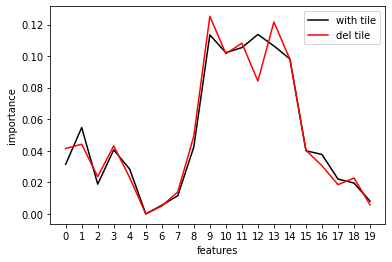

In [99]:
from sklearn.metrics import confusion_matrix
import matplotlib.ticker as ticker

def cross_validation(data_all):
    np.random.shuffle(data_all)
    rows=data_all.shape[0]
    print("rows=",rows)
    separate_list=range(0,rows,20)
    predictions=[]
    truth=[]
    for rep in range(20):
        for i in range(len(separate_list)-1):
    #         print("\n",separate_list[i])
            Xy_dev=data_all[separate_list[i]:separate_list[i+1],:]
            Xy_train1=data_all[:separate_list[i],:]
            Xy_train2=data_all[separate_list[i+1]:,:]
            if Xy_train1.shape[0]>0 and Xy_train2.shape[0]>0:
                Xy_train=np.vstack((Xy_train1,Xy_train2))
            elif Xy_train1.shape[0]>0:
                Xy_train=Xy_train1
            else:
                Xy_train=Xy_train2
            X_train=Xy_train[:,:20]
            y_train=Xy_train[:,20]
            X_dev=Xy_dev[:,:20]
            y_dev=Xy_dev[:,20]
            pred,clf=random_forest_classifier(X_train, y_train, X_dev, y_dev)
#             pred=decision_tree_classifier(X_train, y_train, X_dev, y_dev)
            predictions.append(pred)
            truth.append(y_dev)
    
    predictions=np.array(predictions).reshape(-1,)
#     print(predictions.shape)
    truth=np.array(truth).reshape(-1,)
    print("Summary: \n", classification_report(truth, predictions))    
    print(confusion_matrix(truth, predictions))
    print("FI:",clf.feature_importances_)
    return confusion_matrix(truth, predictions),clf.feature_importances_

# confusion_matrix0,fi0=cross_validation(data_all_0)#reference
confusion_matrix_,fi_=cross_validation(X_y_data)#with multimode
confusion_matrix1,fi1=cross_validation(X_y_data1)#del multimode
# confusion_matrix2,fi2=cross_validation(X_y_data2)#evaluate conf
# confusion_matrix3,fi3=cross_validation(X_y_data3)#only pickaxe

plt.title("")
x_axis=range(20)
plt.plot(x_axis,fi_,'black',label='with tile')
plt.plot(x_axis,fi1,'r',label='del tile')
# plt.plot(x_axis,fi2,'g',label='eva conf')
# plt.plot(x_axis,fi3,'b',label='only pickaxe')
# plt.plot(x_axis,fi0,'gold',label='sudo')
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(range(len(x_axis)))

plt.legend()
plt.show()

In [100]:
def train_save_RF(data,name):
    clf = RandomForestClassifier(max_depth=20
                                 , min_samples_leaf=2
                                 , max_features="log2"
                                 , n_estimators=100
                                 #,random_state=0
                                )
    X_train=data[:,:20]
    y_train=data[:,20]
    clf.fit(X_train, y_train)
    dump(clf, 'RF-'+name+'.model')
    
train_save_RF(X_y_data,"origin")
train_save_RF(X_y_data1,"optim")

In [104]:
np.save("data_origin.npy",X_y_data, allow_pickle=True, fix_imports=True)
np.save("data_optim.npy",X_y_data1, allow_pickle=True, fix_imports=True)

In [120]:
input_tuple=[0]*20
input_tuple[0]=seq_0[0]
input_tuple[1]=seq_1[0]
input_tuple[2]=seq_2[0]
input_tuple[3]=seq_3[0]
input_tuple[4]=seq_4[0]
input_tuple[5:20]=X_y_data[0,5:20]
np.save("demo_data.npy",input_tuple, allow_pickle=True, fix_imports=True)

In [119]:
input_tuple=np.load("demo_data.npy",allow_pickle=True)
input_tuple.shape

(20,)

In [3]:
def test(data,filename):
    clf = load(filename)
    X_dev=data[:,:20].reshape((-1,20))
    y_dev=data[:,20:].reshape((-1,1))
    prediction = clf.predict(X_dev)
    print("Decision tree \n", classification_report(y_dev, prediction))
    print(confusion_matrix(y_dev, prediction))
    
    estimator=clf.estimators_[0]
#     print(export_text(estimator))
    
    plt.figure(figsize=(50,50))
    plot_tree(estimator, filled=True)
    plt.savefig('./rf-0.jpeg')
    plt.show()
    return prediction,clf.feature_importances_

prediction1,fi2=test(X_y_data1,"RF-optim.model")
prediction2, fi1=test(X_y_data,"RF-origin.model")
# print(prediction1)
# print(prediction2)

plt.title("")
x_axis=range(20)
plt.plot(x_axis,fi1,'black',label='with multi-major')
plt.plot(x_axis,fi2,'r',label='del multi-major')
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(range(len(x_axis)))
plt.legend()
plt.show()

NameError: name 'X_y_data1' is not defined

## Other exploring

In [7]:
hier_list2=np.zeros([233,11])
# hier_list2[:,0]=np.argwhere(ir_reward==1)
for i in range (233):
    for j in range (9):
        idx=np.argwhere(ir_reward[i]==2**j)
        if idx.shape==(1,1):
            hier_list2[i][j]=idx[0][0]
        elif idx.shape==(2,1): 
            hier_list2[i][j]=idx[0][0]
            if j==2:
                hier_list2[i][9]=idx[1][0]
            else:
                hier_list2[i][10]=idx[1][0]
        else:
            hier_list2[i][j]=-1

kmeans2_1 = KMeans(n_clusters=3, random_state=0).fit(hier_list2)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.


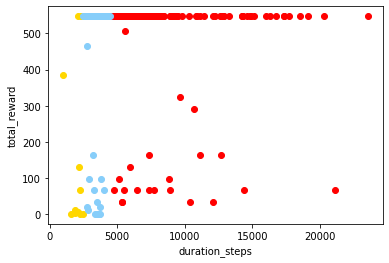

In [8]:
import matplotlib.pyplot as plt
color=['r','gold','lightskyblue']

def plot_label(total_reward, duration_steps, label):
    plt.title("")
    for i in range(len(duration_steps)):
        plt.scatter(duration_steps[i],total_reward[i],label=label[i],color=color[label[i]])   
    plt.xlabel("duration_steps")
    plt.ylabel("total_reward")
    plt.show()
    
plot_label(ir_total_reward, ir_duration_steps, kmeans.labels_)

In [ ]:
plot_label(irD_total_reward, ir_duration_steps, kmeans.labels_)

In [ ]:
plot_label(ir_total_reward, ir_duration_steps, kmeans2_1.labels_)

In [ ]:
plot_label(irD_total_reward, ir_duration_steps, kmeans2_1.labels_)

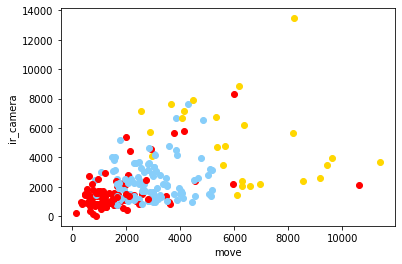

In [35]:
import matplotlib.pyplot as plt
color=['r','gold','lightskyblue']

def plot_label(x_data, y_data, label, xl, yl):
    plt.title("")
    for i in range(len(y_data)):
        plt.scatter(y_data[i],x_data[i],label=label[i],color=color[label[i]])   
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.show()
    
plot_label(ir_attack, ir_camera, kmeans2_1.labels_,'move','ir_camera')

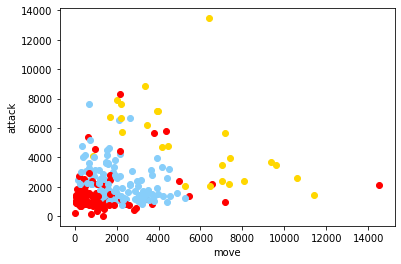

In [36]:
plot_label(ir_attack, ir_moves, kmeans2_1.labels_,'move','attack')

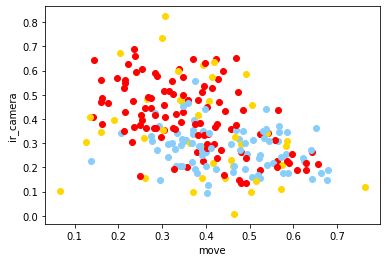

In [39]:
ir_attack2=np.array(ir_attack)/np.array(ir_duration_steps)
ir_camera2=np.array(ir_camera)/np.array(ir_duration_steps)
plot_label(ir_attack2, ir_camera2, kmeans.labels_,'move','ir_camera')

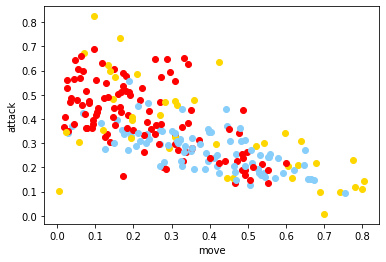

In [45]:
ir_moves2=np.array(ir_moves)/np.array(ir_duration_steps)
plot_label(ir_attack2, ir_moves2, kmeans.labels_,'move','attack')

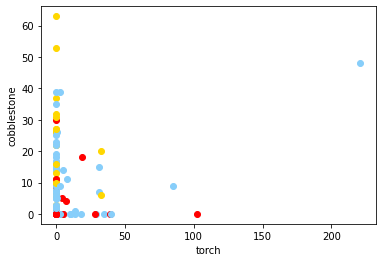

In [43]:
ir_place=np.array(ir_place)
plot_label(ir_place[:,0], ir_place[:,1], kmeans2_1.labels_,'torch','cobblestone')

## Cut videos

In [67]:
pickaxe_step=[]

for i in range (122):
    idx=np.argwhere(reward[i]==256)
    pickaxe_step.append(idx)
    print (i,":", ,idx)

[[6936]]
[[8509]]
[[12205]]
[]
[[5794]]
[[6120]]
[[5615]]
[]
[[11306]]
[[32545]]
[]
[[6531]]
[]
[[12135]]
[]
[[3625]]
[[9635]]
[[10653]]
[[6149]]
[[9355]]
[[3116]]
[]
[[18545]]
[]
[]
[]
[[2928]]
[[8446]]
[[8702]]
[[5969]]
[[18821]]
[[9235]]
[]
[[4141]]
[]
[[7428]]
[]
[[3649]]
[[3125]]
[]
[[15513]]
[]
[[7443]]
[]
[[10308]]
[[9444]]
[[17762]]
[[5620]]
[[10470]]
[]
[[10177]]
[[4971]]
[]
[[6029]]
[[6643]]
[[3640]]
[]
[[34172]]
[[7301]]
[]
[[4595]]
[[4101]]
[[8630]]
[[7571]]
[[7707]]
[]
[[4970]]
[]
[[4182]]
[[18957]]
[[9352]]
[[4082]]
[[5200]]
[[8515]]
[]
[]
[[8621]]
[]
[[13827]]
[[5774]]
[[8232]]
[[3074]]
[[18352]]
[]
[[6002]]
[[11222]]
[[30450]]
[[4534]]
[[10563]]
[[4081]]
[[8468]]
[[11683]]
[[7857]]
[]
[[4378]]
[[5353]]
[[6841]]
[[8082]]
[[11249]]
[[4965]]
[[6946]]
[[14840]]
[[5236]]
[[6567]]
[[6901]]
[[7530]]
[[13457]]
[[8546]]
[[8043]]
[[11325]]
[[5480]]
[]
[[5667]]
[[8313]]
[[5863]]
[[5196]]
[[4174]]
[[6098]]
[]
[]
[]
[[11400]]


In [74]:
stream_name=np.array(stream_name)

duration_steps=np.array(duration_steps)

duration_ms=np.array(duration_ms)
duration_s=duration_ms/1000

true_video_frame_count=np.array(true_video_frame_count)
true_video_frame_count_s=true_video_frame_count/20


pickaxe_step=[]
for i in range (122):
    idx=np.argwhere(reward[i]==256)
    if idx.shape==(1,1):
        pickaxe_step.append(idx[0][0]/20.0)
    else:
        pickaxe_step.append(true_video_frame_count_s[i])
#     print (i,":", ,idx)
    
dic_name_s={}
dic_name_cut={}
for i in range(len(stream_name)):
#     print(stream_name[i], true_video_frame_count[i])
    dic_name_s[stream_name[i]]= true_video_frame_count_s[i]
    dic_name_cut[stream_name[i]]= pickaxe_step[i]
    

for name in sorted(dic_name_cut):
    print(name)
    
print("\n\ncut:")
for name in sorted(dic_name_cut):
    print("%.2f" %dic_name_cut[name])
    
print("\n\ncut in min:")
for name in sorted(dic_name_cut):
    print(int(dic_name_cut[name]/60),':', '%.2f' %(dic_name_cut[name]%60))
    
print("\n\noriginal:")
for name in sorted(dic_name_s):
    print("%.2f" %dic_name_s[name])


v3_absolute_grape_changeling-17_418-2303
v3_absolute_grape_changeling-6_37339-46767
v3_absolute_grape_changeling-9_4643-34456
v3_absolute_zucchini_basilisk-14_12791-21691
v3_aggravating_artichoke_harpy-11_12179-28686
v3_aggravating_artichoke_harpy-11_186-12079
v3_agonizing_kale_tree_nymph-20_16180-39256
v3_agonizing_kale_tree_nymph-20_289-7919
v3_agonizing_kale_tree_nymph-20_39345-43897
v3_agonizing_kale_tree_nymph-20_43999-57348
v3_agonizing_kale_tree_nymph-20_58203-59745
v3_agonizing_kale_tree_nymph-20_7989-16044
v3_agonizing_kale_tree_nymph-4_41105-57631
v3_agonizing_kale_tree_nymph-4_4131-16401
v3_agonizing_kale_tree_nymph-4_580-4067
v3_agonizing_kale_tree_nymph-7_106750-114380
v3_agonizing_kale_tree_nymph-7_133235-141843
v3_agonizing_kale_tree_nymph-7_74962-82761
v3_alarming_arugula_medusa-12_32515-56508
v3_alarming_arugula_medusa-12_962-31988
v3_alarming_arugula_medusa-25_287-18941
v3_all_orange_djinn-4_193-66220
v3_ample_salad_doppelganger-1_14665-50183
v3_ample_salad_doppelgang

In [ ]:
<iframe width="560" height="315" src="https://www.youtube.com/embed/XnuMKoe9-KQ" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [81]:
import pandas as pd
pd_reader = pd.read_csv("./links.csv")
# print(pd_reader)
link_list=pd_reader.values.tolist()
# print(link_list)
link_list=np.array(link_list)
link_list=link_list.flatten()

pre='<iframe width="560" height="315" src="https://www.youtube.com/embed/'
post='" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'


code_list=[]
for item in link_list:
#     youtube_code=item-"https://youtu.be/"
    youtube_code=item[17:]
    print(youtube_code)
    code=pre+youtube_code+post
    code_list.append(code)

print("\n\n\n")
for item in code_list:    
    print(item)
    
    

BJgtn13MkMM
DSwI500TXIw
pT7Hk4cnZt4
H6U8u-Y3r78
QA9ovWOkUFs
XotMJ7wmKOI
Xp8zxmbYSr4
YxiJvyM3XOc
G1IXv0A4mhY
DGTHuMNMgcY
RwIH3t_m5DI
NDsKG3tjVTc
FzQgyqm7QQw
SPF_25hs5Ng
yPiJdfqX_wE
xmrNRH2m_0Q
u0GAtnrk594
qfNPD69pquo
JxGg-rWc6uk
NSsswZIK3HE
ZUaawKsG4wI
vGEPfO3hwCM
_Qh1RIp8KFU
6zNc62PojpA
nmQprUPTlbA
y9pp3C9Nyao
ktMXp6RePEs
Q6LJOuUv7JI
jja9NfaxLd0
ouTFxf70aI8
udcVBVP9f9s
X5-RNpjI64s
e45Ege_o_d8
IikjLkcEAlg
ej-oLsTRriw
YKHrcGUg8cQ
CrtVnFzLRhQ
PAibiwVZ5RU
NFIgHN5Qzno
k7j6TwrgbS0
KJWN94ZLtd8
zBzSw2qFBmk
32cIKRfG5e0
Fd12XAZ5E6g
pryEbN4yJAs
zncvYGVO46E
LXga1pBgd-A
xFqI3JETT88
Uw2RCVoRYfA
GqWNXVYvVtE
WiSwMwsHl28
_JiMGN_j_Z8
LoIrXH7596g
3xuQfXDBAMc
dun7NEuidU0
PfB3IvX-A4M
CDPoCsnj6pg
eKfQCIGooqQ
FXVCcYgu0M0
x928sMo28zI
zC3Eo4V1Qoc
g64e8UsmBag
KJix5yNtXwI
dIIuf3XsoaI
aUFozz2r1e0
tw6Jwnb91xI
VLjAHERgNvs
eOSq9xfyhMc
ynEMhtOwBJk
UMJn51k7Q5c
G05e4CeOS7g
Lfrl23U8XfA
Sefo2k3q0hQ
X3-DJ4oa6vA
GE6Vu-AKR58
8Vjs-uHKeLk
uBrHPNOYMgc
tmZ6WWk6MQg
My-1gfV7XIE
Q2Ree1mzVV8
-cGDqcPG3Js
EeOdiO_Exsw
QJs7yiOcXeI
Q6zv